In [1]:
### a. Import necessary libraries

import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
### b. Get data 

dataset = pd.read_csv('banana_quality.csv')
# Change the labels to 0 or 1
class_names = {
    'Good': 1,
    'Bad': 0
}
dataset['Quality'] = dataset['Quality'].apply(lambda x: class_names[x])
# Split into features and labels
X, y = dataset.iloc[:, 0:7].values, dataset['Quality'].values
print(f'Features shape: {X.shape}\nLabels shape: {y.shape}')
print(f'First features: {X[0]}\nFirst label: {y[0]}')

Features shape: (8000, 7)
Labels shape: (8000,)
First features: [-1.9249682   0.46807805  3.0778325  -1.4721768   0.2947986   2.4355695
  0.27129033]
First label: 1


In [3]:
### c. Split data into train and test

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

len(X_train), len(X_test), len(y_train), len(y_test)

(5600, 2400, 5600, 2400)

In [4]:
### d. Define Model Architecture

class BinaryClassV0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.linear2 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model_0 = BinaryClassV0(input_dim=7, hidden_dim=16, output_dim=1)
model_0

BinaryClassV0(
  (linear1): Linear(in_features=7, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
)

In [5]:
### e. Setup loss fn and optimizer

loss_fn = nn.BCEWithLogitsLoss() # with sigmoid built-in
optimzier = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [6]:
### f. Evaluation metric

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [7]:
### g. Train model

epochs = 100
model_0_results = {
    'train_acc': [],
    'train_loss': [],
    'test_acc': [],
    'test_loss': []
}

for epoch in range(epochs):
    ### Training
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_train, y_pred)
    model_0_results['train_loss'].append(train_loss.item())
    model_0_results['train_acc'].append(train_acc)
    optimzier.zero_grad()
    train_loss.backward()
    optimzier.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test, y_test_pred)
        model_0_results['test_loss'].append(test_loss.item())
        model_0_results['test_acc'].append(test_acc)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc:.3f}% | Test acc: {test_acc:.3f}%')

Epoch: 0 | Train loss: 0.87192 | Test loss: 0.74267 | Train acc: 39.643% | Test acc: 50.167%
Epoch: 10 | Train loss: 0.47017 | Test loss: 0.44989 | Train acc: 79.875% | Test acc: 81.625%
Epoch: 20 | Train loss: 0.39134 | Test loss: 0.37752 | Train acc: 84.161% | Test acc: 85.208%
Epoch: 30 | Train loss: 0.35300 | Test loss: 0.34246 | Train acc: 85.536% | Test acc: 86.292%
Epoch: 40 | Train loss: 0.33176 | Test loss: 0.32317 | Train acc: 86.393% | Test acc: 86.458%
Epoch: 50 | Train loss: 0.31916 | Test loss: 0.31172 | Train acc: 86.536% | Test acc: 86.667%
Epoch: 60 | Train loss: 0.31128 | Test loss: 0.30450 | Train acc: 86.786% | Test acc: 87.125%
Epoch: 70 | Train loss: 0.30613 | Test loss: 0.29971 | Train acc: 86.911% | Test acc: 87.125%
Epoch: 80 | Train loss: 0.30261 | Test loss: 0.29636 | Train acc: 87.107% | Test acc: 87.208%
Epoch: 90 | Train loss: 0.30010 | Test loss: 0.29391 | Train acc: 87.161% | Test acc: 87.458%


In [8]:
### h. Improve model

class BinaryClassV1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.linear3 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

model_1 = BinaryClassV1(input_dim=7, hidden_dim=16, output_dim=1)
model_1

BinaryClassV1(
  (linear1): Linear(in_features=7, out_features=16, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
)

In [9]:
### i. Define hyperparameters

loss_fn = nn.BCEWithLogitsLoss()
optimzier = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [10]:
### j. Train model

epochs = 100
model_1_results = {
    'train_acc': [],
    'train_loss': [],
    'test_acc': [],
    'test_loss': []
}

for epoch in range(epochs):
    ### Training
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_train, y_pred)
    model_1_results['train_loss'].append(train_loss.item())
    model_1_results['train_acc'].append(train_acc)
    optimzier.zero_grad()
    train_loss.backward()
    optimzier.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        y_test_logits = model_1(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test, y_test_pred)
        model_1_results['test_loss'].append(test_loss.item())
        model_1_results['test_acc'].append(test_acc)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {train_acc:.3f}% | Test acc: {test_acc:.3f}%')

Epoch: 0 | Train loss: 0.68783 | Test loss: 0.67662 | Train acc: 49.411% | Test acc: 52.167%
Epoch: 10 | Train loss: 0.64710 | Test loss: 0.63420 | Train acc: 57.982% | Test acc: 62.167%
Epoch: 20 | Train loss: 0.58624 | Test loss: 0.56942 | Train acc: 68.911% | Test acc: 72.208%
Epoch: 30 | Train loss: 0.50693 | Test loss: 0.48773 | Train acc: 78.964% | Test acc: 80.833%
Epoch: 40 | Train loss: 0.43263 | Test loss: 0.41443 | Train acc: 84.625% | Test acc: 86.000%
Epoch: 50 | Train loss: 0.37669 | Test loss: 0.36041 | Train acc: 86.982% | Test acc: 88.208%
Epoch: 60 | Train loss: 0.33659 | Test loss: 0.32182 | Train acc: 88.536% | Test acc: 89.750%
Epoch: 70 | Train loss: 0.30533 | Test loss: 0.29175 | Train acc: 89.446% | Test acc: 90.542%
Epoch: 80 | Train loss: 0.27858 | Test loss: 0.26590 | Train acc: 90.268% | Test acc: 91.167%
Epoch: 90 | Train loss: 0.25431 | Test loss: 0.24241 | Train acc: 91.018% | Test acc: 91.958%


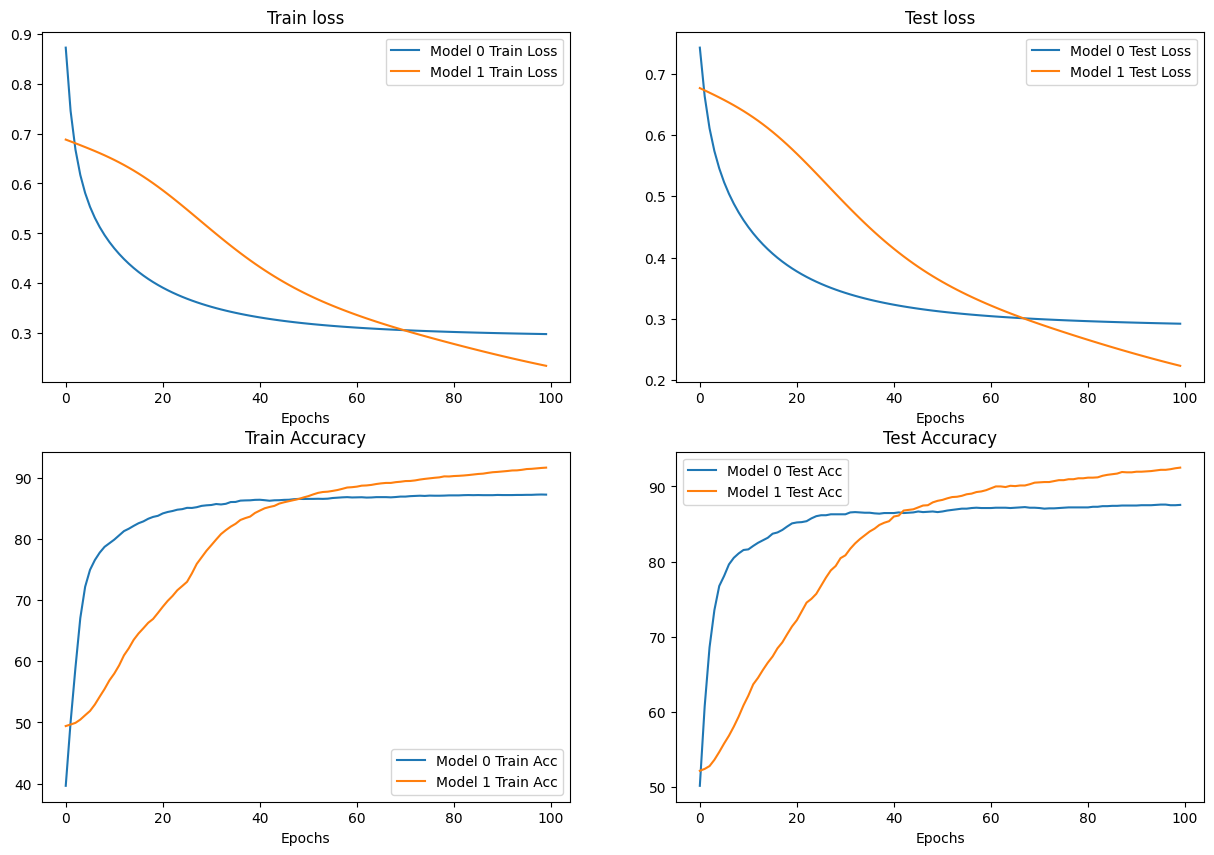

In [13]:
### k. Plot results of both models

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), model_0_results['train_loss'], label = 'Model 0 Train Loss')
plt.plot(range(epochs), model_1_results['train_loss'], label = 'Model 1 Train Loss')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), model_0_results['test_loss'], label = 'Model 0 Test Loss')
plt.plot(range(epochs), model_1_results['test_loss'], label = 'Model 1 Test Loss')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(epochs), model_0_results['train_acc'], label = 'Model 0 Train Acc')
plt.plot(range(epochs), model_1_results['train_acc'], label = 'Model 1 Train Acc')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(epochs), model_0_results['test_acc'], label = 'Model 0 Test Acc')
plt.plot(range(epochs), model_1_results['test_acc'], label = 'Model 1 Test Acc')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()